In [1]:
# Adapted from Chapter 9
# Use the file named: booksales_clean_for_modeling.csv
# This was cleaned for easier access later

# This was also run not on GPU as the data was quite small and no major complexity

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
# parameters defined
EPOCHS = 100
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = 'data/booksales_clean_for_modeling.csv'

In [31]:
def readfile(file_name):
  file = open(file_name, 'r', encoding='utf-8')
  next(file)
  data = []
  for line in (file):
    values = line.split(',')
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float32)

In [32]:
# Read data and then split train/test partitions
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

In [33]:
train_sales[0:10]

array([790., 539., 535., 523., 552., 589., 592., 894., 861., 645.],
      dtype=float32)

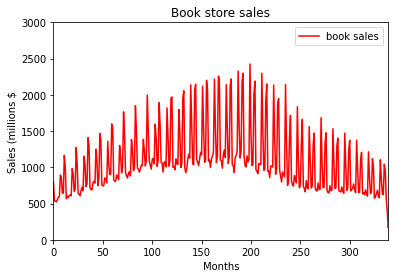

In [34]:
# plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0,339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $')
plt.legend()
plt.show()

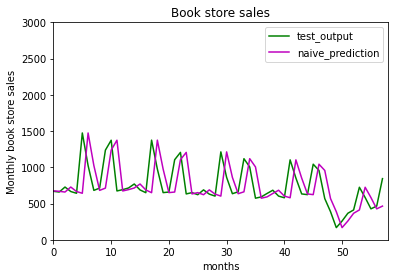

In [35]:
# Plotting naive predictions
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive_prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [36]:
# Similar as before during MNIST, use this time to standardize train/test data
mean = np.mean(train_sales)
stddev = np.mean(train_sales)
train_sales_std = (train_sales - mean) / stddev
test_sales_std = (test_sales - mean) / stddev

In [48]:
# Create training examples
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1))
train_y = np.zeros((train_months-MIN, 1))

for i in range(0, train_months-MIN):
  train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
  train_y[i,0] = train_sales_std[i+MIN]

In [49]:
# Create test examples
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1))
test_y = np.zeros((test_months-MIN, 1))
for i in range(0, test_months-MIN):
  test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
  test_y[i, 0] = test_sales_std[i+MIN]

In [50]:
# Now, finally creating RNN model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(None,1)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(train_X, train_y, validation_data = (test_X, test_y), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2, shuffle=True)

Epoch 1/100
17/17 - 3s - loss: 0.1133 - mean_absolute_error: 0.2550 - val_loss: 0.1006 - val_mean_absolute_error: 0.2908 - 3s/epoch - 177ms/step
Epoch 2/100
17/17 - 1s - loss: 0.0647 - mean_absolute_error: 0.2056 - val_loss: 0.0355 - val_mean_absolute_error: 0.1486 - 921ms/epoch - 54ms/step
Epoch 3/100
17/17 - 1s - loss: 0.0277 - mean_absolute_error: 0.1302 - val_loss: 0.0190 - val_mean_absolute_error: 0.0940 - 918ms/epoch - 54ms/step
Epoch 4/100
17/17 - 1s - loss: 0.0163 - mean_absolute_error: 0.1021 - val_loss: 0.0186 - val_mean_absolute_error: 0.1001 - 983ms/epoch - 58ms/step
Epoch 5/100
17/17 - 1s - loss: 0.0101 - mean_absolute_error: 0.0794 - val_loss: 0.0132 - val_mean_absolute_error: 0.0761 - 844ms/epoch - 50ms/step
Epoch 6/100
17/17 - 1s - loss: 0.0083 - mean_absolute_error: 0.0710 - val_loss: 0.0154 - val_mean_absolute_error: 0.0904 - 778ms/epoch - 46ms/step
Epoch 7/100
17/17 - 1s - loss: 0.0080 - mean_absolute_error: 0.0684 - val_loss: 0.0077 - val_mean_absolute_error: 0.0534

In [53]:
# Create naive predictions based on standardized data
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.06842883
naive test mean abs:  0.18290438


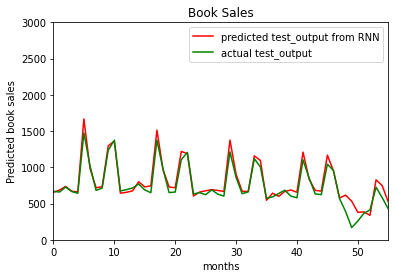

In [54]:
# Now, using the model for prediction of train and test as well as destandardizing the results

predicted_test = model.predict(test_X, len(test_X))
predicted_test = np.reshape(predicted_test, (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plotting
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'r-', label='predicted test_output from RNN')
plt.plot(x, test_sales[-(len(test_sales)-MIN):], 'g-', label='actual test_output')
plt.title('Book Sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()